In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

# loc_mask prepare

In [2]:
loc_site=read_img(spei_path+"Elephant_locs_001_240820_update.tif")[0]
loc_site[loc_site<=0]=np.nan
np.nanmin(loc_site),np.nanmax(loc_site)

(1.0, 1.0)

In [3]:
np.nanmean(loc_site)

1.0

In [4]:
mask=np.zeros((260,316))
for i in range(260):
    for j in range(316):
        bloc_dist=loc_site[i*25:(i+1)*25,j*25:(j+1)*25]
        aa=np.nansum(bloc_dist)
        if aa>0:
            mask[i,j]=1
        else:
            mask[i,j]=np.nan

In [5]:
np.nanmax(mask)

1.0

# vegetation structure

## 求Δ

In [6]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'Forest-structure_DEAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_DAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_DEAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_DAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [7]:
res_name=['treeH','th_Lang','tc_planet','tc_Hansen10']
delta=[]
for i in range(4):
    f1=np.load(drv_path+'Forest-structure_DEAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(260, 316)

In [8]:
ddl=[]#TH_delta,TC_delta
for i in range(4):
    ddl.append(delta[i]*mask)

In [9]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

tree_delta=[]
for i in range(4):
    tree_delta.append(kill_nan(ddl[i]))

In [10]:
len(tree_delta[0]),len(tree_delta[1]),len(tree_delta[2]),len(tree_delta[3])

(154, 156, 154, 156)

In [11]:
np.mean(tree_delta[0]),np.mean(tree_delta[1]),np.mean(tree_delta[2]),np.mean(tree_delta[3])

(1.0352267057864697, 0.9690921952386793, 3.079725423416534, 3.4585760961740446)

## 求se

In [12]:
#res_name=['treeH','th_Lang','tc_planet','tc_Hansen10','Bio']
se=[]
for i in range(4):
    se.append(stats.sem(tree_delta[i]))
se

[0.2748120345979721,
 0.21941540197331924,
 1.1512135175967835,
 0.8612476016059761]

## significances

In [13]:
pp_value_veg=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(4):
    f1=np.load(drv_path+'Forest-structure_DEAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask*mask
    f2=np.load(drv_path+'Forest-structure_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask*mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value_veg.append(p)
pp_value_veg #p value of ndvi_res and csif_res

[0.00284070680959174,
 4.638807701601117e-05,
 0.008204339017880528,
 0.00010135206871558081]

## fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


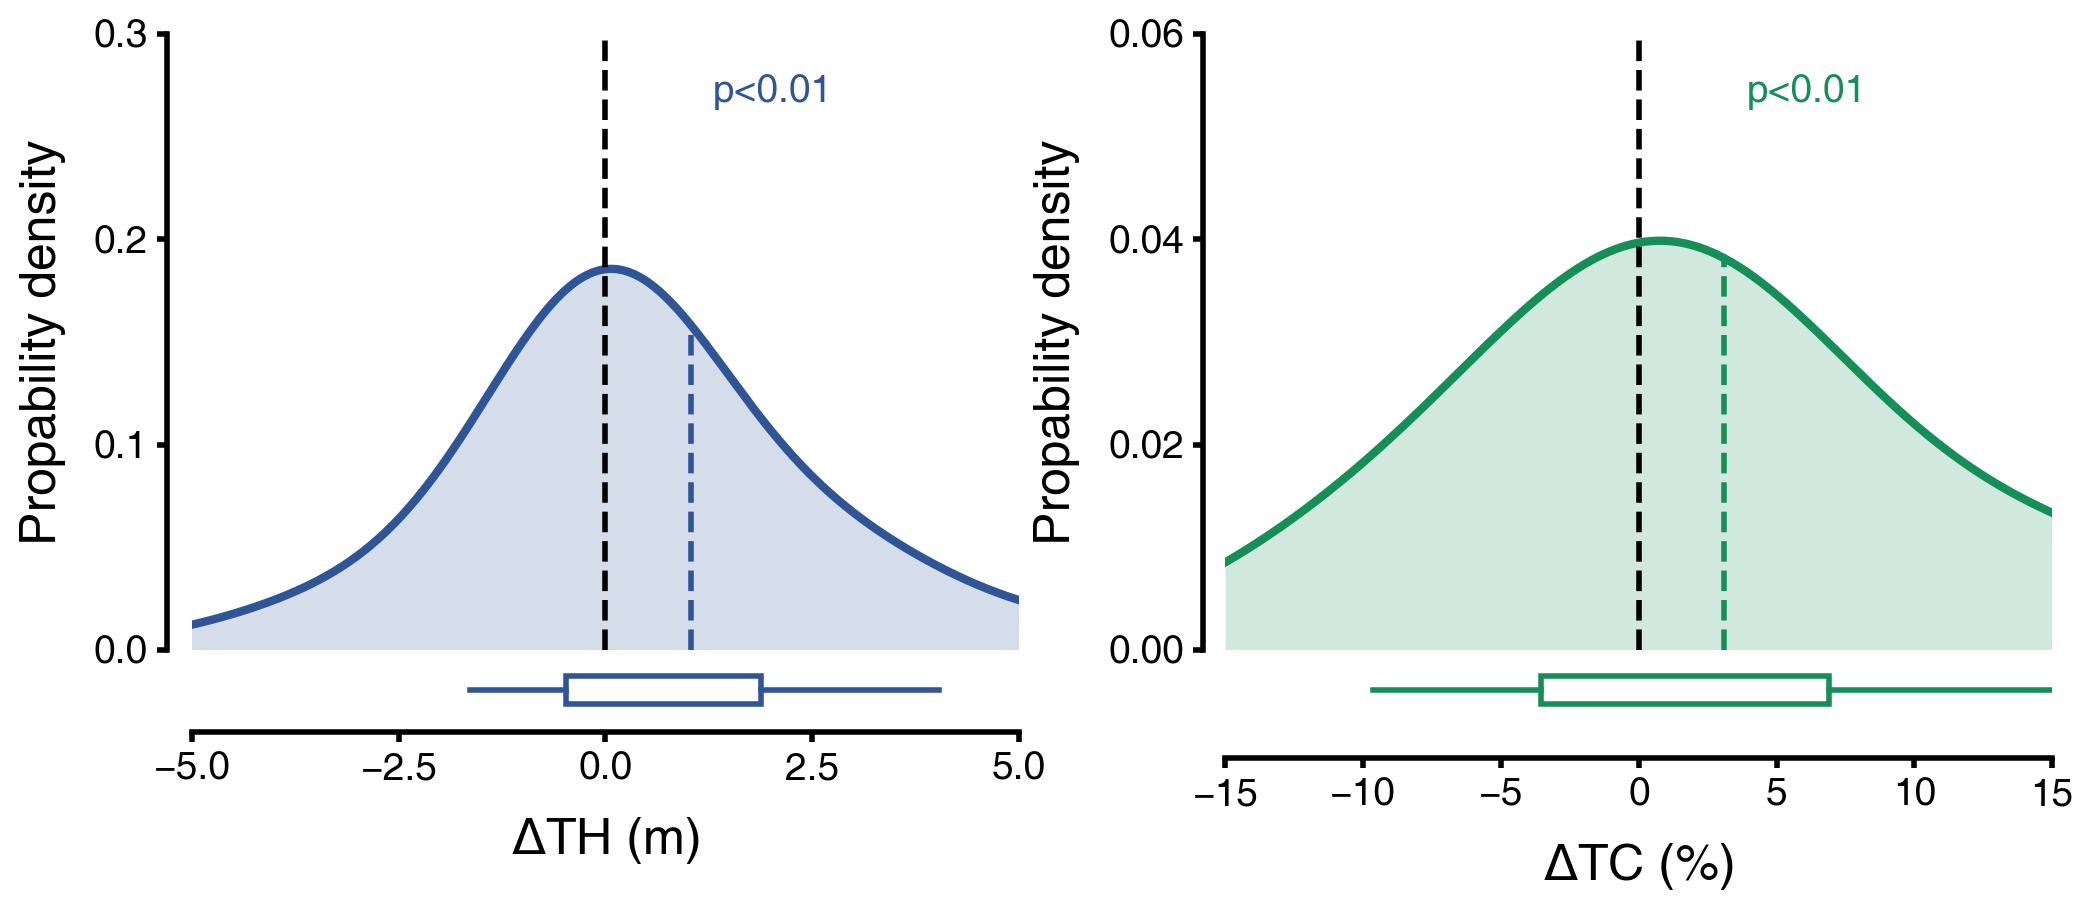

In [14]:
#['treeH','tc_planet']
#['treeH','th_Lange','tc_planet','tc_Hansen10','Bio','et','lai']
data_th=tree_delta[0]
data_pp_th=pp_value_veg[0]
data_tc=tree_delta[2]
data_pp_tc=pp_value_veg[2]

data=[data_th,data_tc]
pp=[data_pp_th,data_pp_tc]

import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)  # pass in the font dict as kwargs
cl1 = np.array([(47,85,151)])#,(91,155,213)
cl2 = np.array([(22,142,88)])#,(146,208,80)
cl=[cl1/255,cl2/255]
#cl=['C0','salmon']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label1=['TH from Potapov $\mathit{et}$ $\mathit{al.}$','TH from Lang $\mathit{et}$ $\mathit{al.}$']
label2=['TC from Reiner $\mathit{et}$ $\mathit{al.}$','TC from Hansen $\mathit{et}$ $\mathit{al.}$']
label=[label1,label2]
tx=['(m)','(%)']
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    x=np.linspace(-15,15,1000)
    mean=np.nanmean(data[i])
    delta_rav=gc.nanravel(data[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    ax.plot(x,z,lw=3,color=cl[i])#,label=label[i]
    ax.fill_between(x,0,z,facecolor=cl[i],alpha=0.2)
    #ax.fill_between(np.linspace(0,15,500),0,kenal.evaluate(np.linspace(0,15,500)),facecolor=cl[i],alpha=0.2)
    #sns.distplot(data[i],bins = 100,hist = True,kde = True,rug = False,norm_hist=False,color = 'green')
    ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i])
    if pp[i]<0.001:
        #ax.text(0.73,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[i][j])
        ax.text(0.73,0.89, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[i])
    elif pp[i]<0.01:
        ax.text(0.63,0.89, 'p<0.01', fontsize=14,transform = ax.transAxes,color=cl[i])
    elif pp[i]<0.05:
        ax.text(0.63,0.89, '{:.2f} *'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i])
    else:
        ax.text(0.63,0.89, '{:.3f} (p={:.2f})'.format(mean,data_pp[i]), fontsize=14,transform = ax.transAxes,color=cl[i])
    if i ==0:
        ax.vlines(0,0,0.3,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.3)
        ax.set_yticks(np.arange(0,0.31,0.1))
        ax.set_xlim(-5,5)
        ax.set_xticks(np.arange(-5,5.1,2.5))
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-5.3))
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',-0.04))
        ax.set_xlabel('$\Delta$TH (m)',labelpad=10)
    else:
        ax.vlines(0,0,0.06,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.06)
        ax.set_yticks(np.arange(0,0.061,0.02))
        ax.set_xlim(-15,15)
        ax.set_xticks(np.arange(-15,15.1,5))
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-15.8))
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',-0.0105))
        ax.set_xlabel('$\Delta$TC (%)',labelpad=10)
    ax.legend(fontsize=14,loc='upper left',frameon=False,handlelength=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('Propability density',labelpad=10)
    
    ax.xaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)

    ax.tick_params(labelsize=14)
    ax.yaxis.label.set_size(18)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
#添加箱线图----------------------------
    if i ==0:
        ax1=fig.add_axes([0.122,-0,0.35,0.12])#左，底，宽，高
        ax1.set_xlim(-5,5)
        ax1.set_xticks(np.arange(-5,5,2.5))
        ax1.axis('off')
    else:
        ax1=fig.add_axes([0.55,-0,0.35,0.12])#左，底，宽，高
        ax1.set_xlim(-15,15)
        ax1.set_xticks(np.arange(-15,15,5))
        ax1.axis('off')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
    #ax.spines['bottom'].set_visible(False)
    bplot=ax1.boxplot(data[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':cl[i],"markeredgecolor":cl[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":cl[i],"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": cl[i],"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':cl[i]},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i],'color':cl[i]})
    
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_c-d.tif", dpi=600, bbox_inches = 'tight')

# LST

In [15]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

In [256]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [257]:
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask_area=hfp#*forest_mask
mask_area[~np.isnan(mask_area)]=1
np.nanmin(mask_area),np.nanmax(mask_area)

(1.0, 1.0)

In [258]:
lst=read_img(spei_path+'lst_1516_afr_001.tif')[0]
lst=lst*0.02-273.15

## moving window

In [259]:
"""
2023/11/25
supply paired sites methods.
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask_area,DAA*mask_area]
res_pool=[lst,dem,slope] #protect need conver to fraction
dist_name=['DEAA','DAA']
res_name=['lst','dem','slope']

# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(2):
    for j in range(3):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('LST_{}_{}_0.25deg_240821.npy'.format(dist_name[i],res_name[j]))
aa_name

['LST_DEAA_lst_0.25deg_240821.npy',
 'LST_DEAA_dem_0.25deg_240821.npy',
 'LST_DEAA_slope_0.25deg_240821.npy',
 'LST_DAA_lst_0.25deg_240821.npy',
 'LST_DAA_dem_0.25deg_240821.npy',
 'LST_DAA_slope_0.25deg_240821.npy']

In [260]:
for i in range(6):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(drv_path+aa_name[i],kk)

执行任务0 (23872)...
执行任务1 (23872)...
执行任务2 (23872)...
执行任务3 (23872)...
执行任务4 (23872)...
执行任务5 (23872)...


In [16]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'LST_DEAA_dem_0.25deg_240821.npy',allow_pickle=True)
dem2=np.load(drv_path+'LST_DAA_dem_0.25deg_240821.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'LST_DEAA_slope_0.25deg_240821.npy',allow_pickle=True)
slo2=np.load(drv_path+'LST_DAA_slope_0.25deg_240821.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [17]:
f1=np.load(drv_path+'LST_DEAA_lst_0.25deg_240821.npy',allow_pickle=True)*dd_mask
f2=np.load(drv_path+'LST_DAA_lst_0.25deg_240821.npy',allow_pickle=True)*dd_mask
ff=f1-f2
ddl=ff*mask

In [18]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

lst_delta=kill_nan(ddl)

In [19]:
se=stats.sem(lst_delta)
se

0.13137757995583327

In [20]:
np.mean(lst_delta)

-0.28600030643924784

## significants

In [21]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

f1=np.load(drv_path+'LST_DEAA_lst_0.25deg_240821.npy',allow_pickle=True)*dd_mask*mask
f2=np.load(drv_path+'LST_DAA_lst_0.25deg_240821.npy',allow_pickle=True)*dd_mask*mask
ddt=del_nan(f1,f2)
sta,p=stats.wilcoxon(ddt[0],ddt[1])
pp_value_lst=p
pp_value_lst

0.016946848963920964

-0.28600030643924784 [0.32288889]


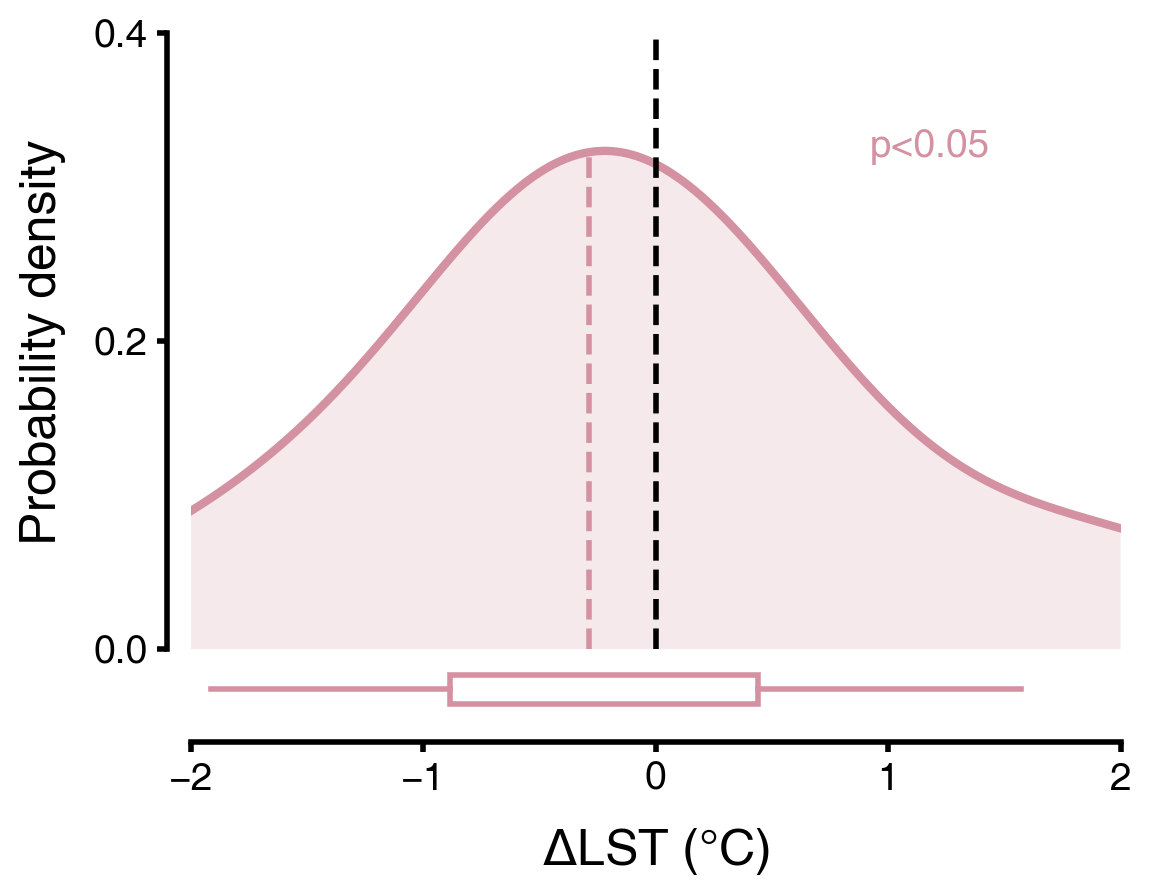

In [22]:
#-*- coding:utf-8 –*-
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(figsize=(6,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl1= np.array([(211,145,161)])
cl2= np.array([(231,195,204)])
cl=[cl1/255,cl1/255]
#cl2=['C0','salmon']
label1=['Drought area']
label2=['Drought area']
label=[label1,label2]

x=np.linspace(-2,2,1000)
mean=np.nanmean(lst_delta)
delta_rav=gc.nanravel(lst_delta)
kenal=gaussian_kde(delta_rav)
z=kenal.evaluate(x)
z_mean=kenal.evaluate(mean)
print(mean,z_mean)
ax.plot(x,z,lw=3,color=cl[0],label=label)
ax.fill_between(x,0,z,facecolor=cl,alpha=0.2)
ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[0])
ax.vlines(0,0,0.8,lw=2,ls='--',color='black')
if pp_value_lst<0.001:
    #ax.text(0.73,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[i][j])
    ax.text(0.73,0.8, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0])
elif pp_value_lst<0.01:
    ax.text(0.73,0.8, 'p<0.01', fontsize=14,transform = ax.transAxes,color=cl[0])
elif pp_value_lst<0.05:
    ax.text(0.73,0.8, 'p<0.05', fontsize=14,transform = ax.transAxes,color=cl[0])
else:
    ax.text(0.73,0.8, '{:.3f} (p={:.2f})'.format(mean,data_pp[i]), fontsize=14,transform = ax.transAxes,color=cl[0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_xlabel('$\Delta$LST (°C)',labelpad=10)

#ax.text(-0.15,1, '(c)', transform = ax.transAxes,color='black',fontsize=20)
ax=plt.gca()
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',-2.1))
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',-0.06))
ax.set_ylim(0,0.4)
ax.set_xlim(-2,2)
ax.set_xticks(np.arange(-2,2.01,1))
ax.set_yticks(np.arange(0,0.401,0.2))
ax.set_ylabel('Probability density',labelpad=10)

ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
#添加箱线图----------------------------
ax1=fig.add_axes([0.122,-0,0.78,0.12])#左，底，宽，高
ax1.set_xlim(-2,2)
ax1.set_xticks(np.arange(-2,2.01,1))
ax1.axis('off')
#ax1.spines['top'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
#ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
#ax.spines['bottom'].set_visible(False)
bplot=ax1.boxplot(lst_delta,
                  vert=False,
                  whis=(10,90),                
                  widths=0.3,
                  patch_artist=True,
                  showmeans=False,
                  meanprops = {'marker':'o','markerfacecolor':cl[0],"markeredgecolor":cl[0],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                  medianprops={'linewidth':'0.5',"color":cl[0],"alpha":0},
                  boxprops={"facecolor": 'none', "edgecolor": cl[0],"linewidth":2,"alpha":1},
                  capprops=None,
                  whiskerprops={'linewidth':'2','color':cl[0]},
                  showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示;
                  showfliers = False,
                  flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[0],'color':cl[0]})
    #rect = ax.patch
    #rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_a-b.tif", dpi=600, bbox_inches = 'tight')

# Resistance

## 求Δ

In [23]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'Resistance_DEAA_dem_0.25deg_240504a.npy',allow_pickle=True)
dem2=np.load(spei_path+'Resistance_DAA_dem_0.25deg_240504a.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Resistance_DEAA_slope_0.25deg_240504a.npy',allow_pickle=True)
slo2=np.load(spei_path+'Resistance_DAA_slope_0.25deg_240504a.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [24]:
res_name=['ndvi_res','csif_res']
delta=[]
d_DAA=[]
d_DEAA=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_DEAA_{}_0.25deg_240504a.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504a.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=(f1-f2)*mask
    delta.append(ff)
    d_DEAA.append(f1)
    d_DAA.append(f2)
delta[0].shape

(260, 316)

In [25]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
mm=[]
pre=[]
relative_delta=[]
for i in range(2):
    tt=np.copy(d_DAA[i])
    tt[tt>1]=np.nan
    tt[tt<=1]=1
    print(np.nanmax(tt))
    mm.append(tt)
    res_delta.append(kill_nan(delta[i]*tt))
    pre=(delta[i]/(1-d_DAA[i]))*100
    #会有一些1000%的异常点，剔除掉，有57个点
    pre_a=np.array(kill_nan(pre*tt))
    pre_a=np.delete(pre_a,np.where((pre_a<-1000)|(pre_a>1000)))#连接符“|”表示or，“&”表示and
    relative_delta.append(pre_a)
np.mean(res_delta[0]),np.mean(res_delta[1])#,relative_delta

1.0
1.0


(0.014535147448380787, 0.028842384048870632)

In [26]:
se=[]
for i in range(2):
    se.append(stats.sem(res_delta[i]))
se

[0.0031948052179942574, 0.005557645353705542]

## significants

In [27]:
pp_value_res=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(2):
    f1=np.load(spei_path+'Resistance_DEAA_{}_0.25deg_240504a.npy'.format(res_name[i]),allow_pickle=True)*dd_mask*mask
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504a.npy'.format(res_name[i]),allow_pickle=True)*dd_mask*mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value_res.append(p)
pp_value_res #p value of ndvi_res and csif_res

[0.018197711535414406, 1.2203955127280796e-05]

## fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.014535147448380787 [12.35661479]
0.028842384048870632 [7.5875289]


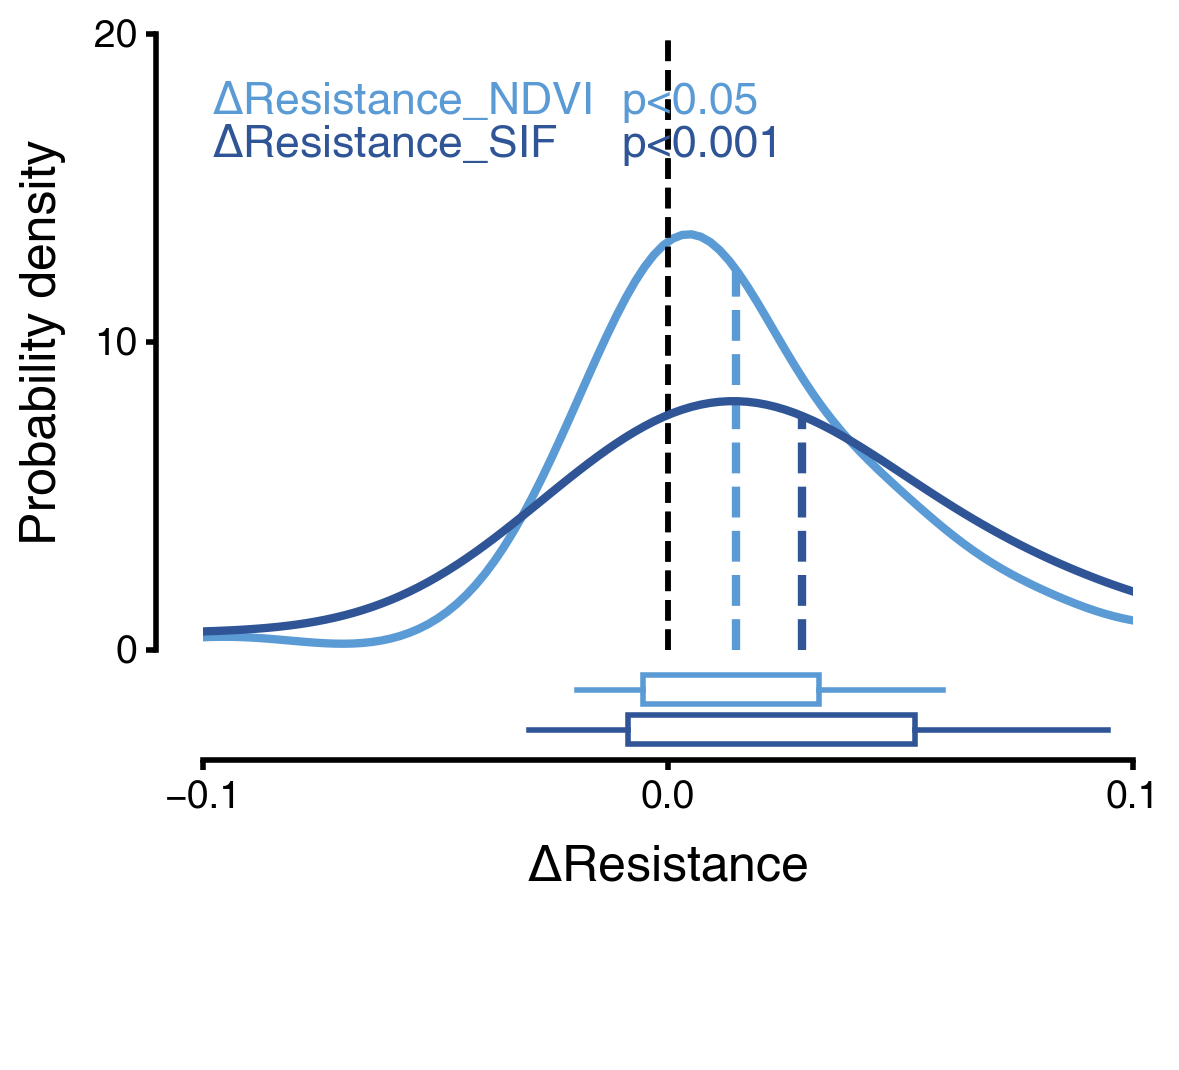

In [28]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(figsize=(6,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.3,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl1 = np.array([(91,155,213),(47,85,151)])
cl2 = np.array([(146,208,80),(22,142,88)])
cl=np.array([(91,155,213),(47,85,151)])/255
tx=['(m)','(%)']
cl2=['C0','salmon']
#res_name=['TH','TC']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label_th=['TH changes in areas with savanna elephants','TH changes in areas with forest elephants']
label_tc=['TC changes in areas with savanna elephants','TC changes in areas with forest elephants']
label=['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF']

for i in range(2):
    x=np.linspace(-0.1,0.1,100)
    ax.vlines(0,0,20,lw=2,ls='--',color='black')
    ax.set_ylim(0,20)
    ax.set_yticks(np.arange(0,20.1,10))
    ax.set_xlim(-0.1,0.1)
    ax.set_xticks(np.arange(-0.1,0.101,0.1))
    ax.set_xlabel('$\Delta$Resistance',labelpad=10)
    mean=np.nanmean(res_delta[i])
    delta_rav=gc.nanravel(res_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)
    ax.plot(x,z,lw=3,color=cl[i])
    ax.vlines(mean,0,z_mean,lw=3,ls='--',color=cl[i])
    if pp_value_res[i]<0.001:
        ax.text(0.45,0.80, "p<0.001", fontsize=16,transform = ax.transAxes,color=cl[1])
        ax.text(0.01,0.80, "$\Delta$Resistance_SIF", fontsize=16,transform = ax.transAxes,color=cl[1])
    elif pp_value_res[i]<0.05:
        ax.text(0.45,0.87, "p<0.05", fontsize=16,transform = ax.transAxes,color=cl[0])
        ax.text(0.01,0.87, "$\Delta$Resistance_NDVI", fontsize=16,transform = ax.transAxes,color=cl[0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.legend(fontsize=12,loc='upper left',frameon=False)

    ax.legend(fontsize=14,loc=(-0.1,-0.65),frameon=False)
    ax=plt.gca()
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',-0.11))
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',-3.6))

    ax.set_ylabel('Probability density',labelpad=10)
    ax.tick_params(labelsize=14)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    if i ==0:
        ax1=fig.add_axes([0.125,-0,0.775,0.12])#左，底，宽，高
    else:
        ax1=fig.add_axes([0.125,-0.05,0.775,0.12])#左，底，宽，高
    ax1.set_xlim(-0.1,0.1)
    ax1.set_xticks(np.arange(--0.1,0.101,0.1))
    ax1.axis('off')

    bplot=ax1.boxplot(res_delta[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':cl[i],"markeredgecolor":cl[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":cl[i],"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": cl[i],"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':cl[i]},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i],'color':cl[i]})

    #rect = ax.patch
    #rect.set_facecolor((202/255,233/255,246/255))
    #fig.savefig("C:/Users/dess/resistance.png", dpi=750, bbox_inches = 'tight')

# fig-combine

In [29]:
data=[tree_delta[0],tree_delta[2],lst_delta,res_delta]
pp_value=[pp_value_veg[0],pp_value_veg[2],pp_value_lst,pp_value_res]
pp_value

[0.00284070680959174,
 0.008204339017880528,
 0.016946848963920964,
 [0.018197711535414406, 1.2203955127280796e-05]]

-0.28600030643924784 [0.32288889]
0.014535147448380787 [12.35661479]
0.028842384048870632 [7.5875289]


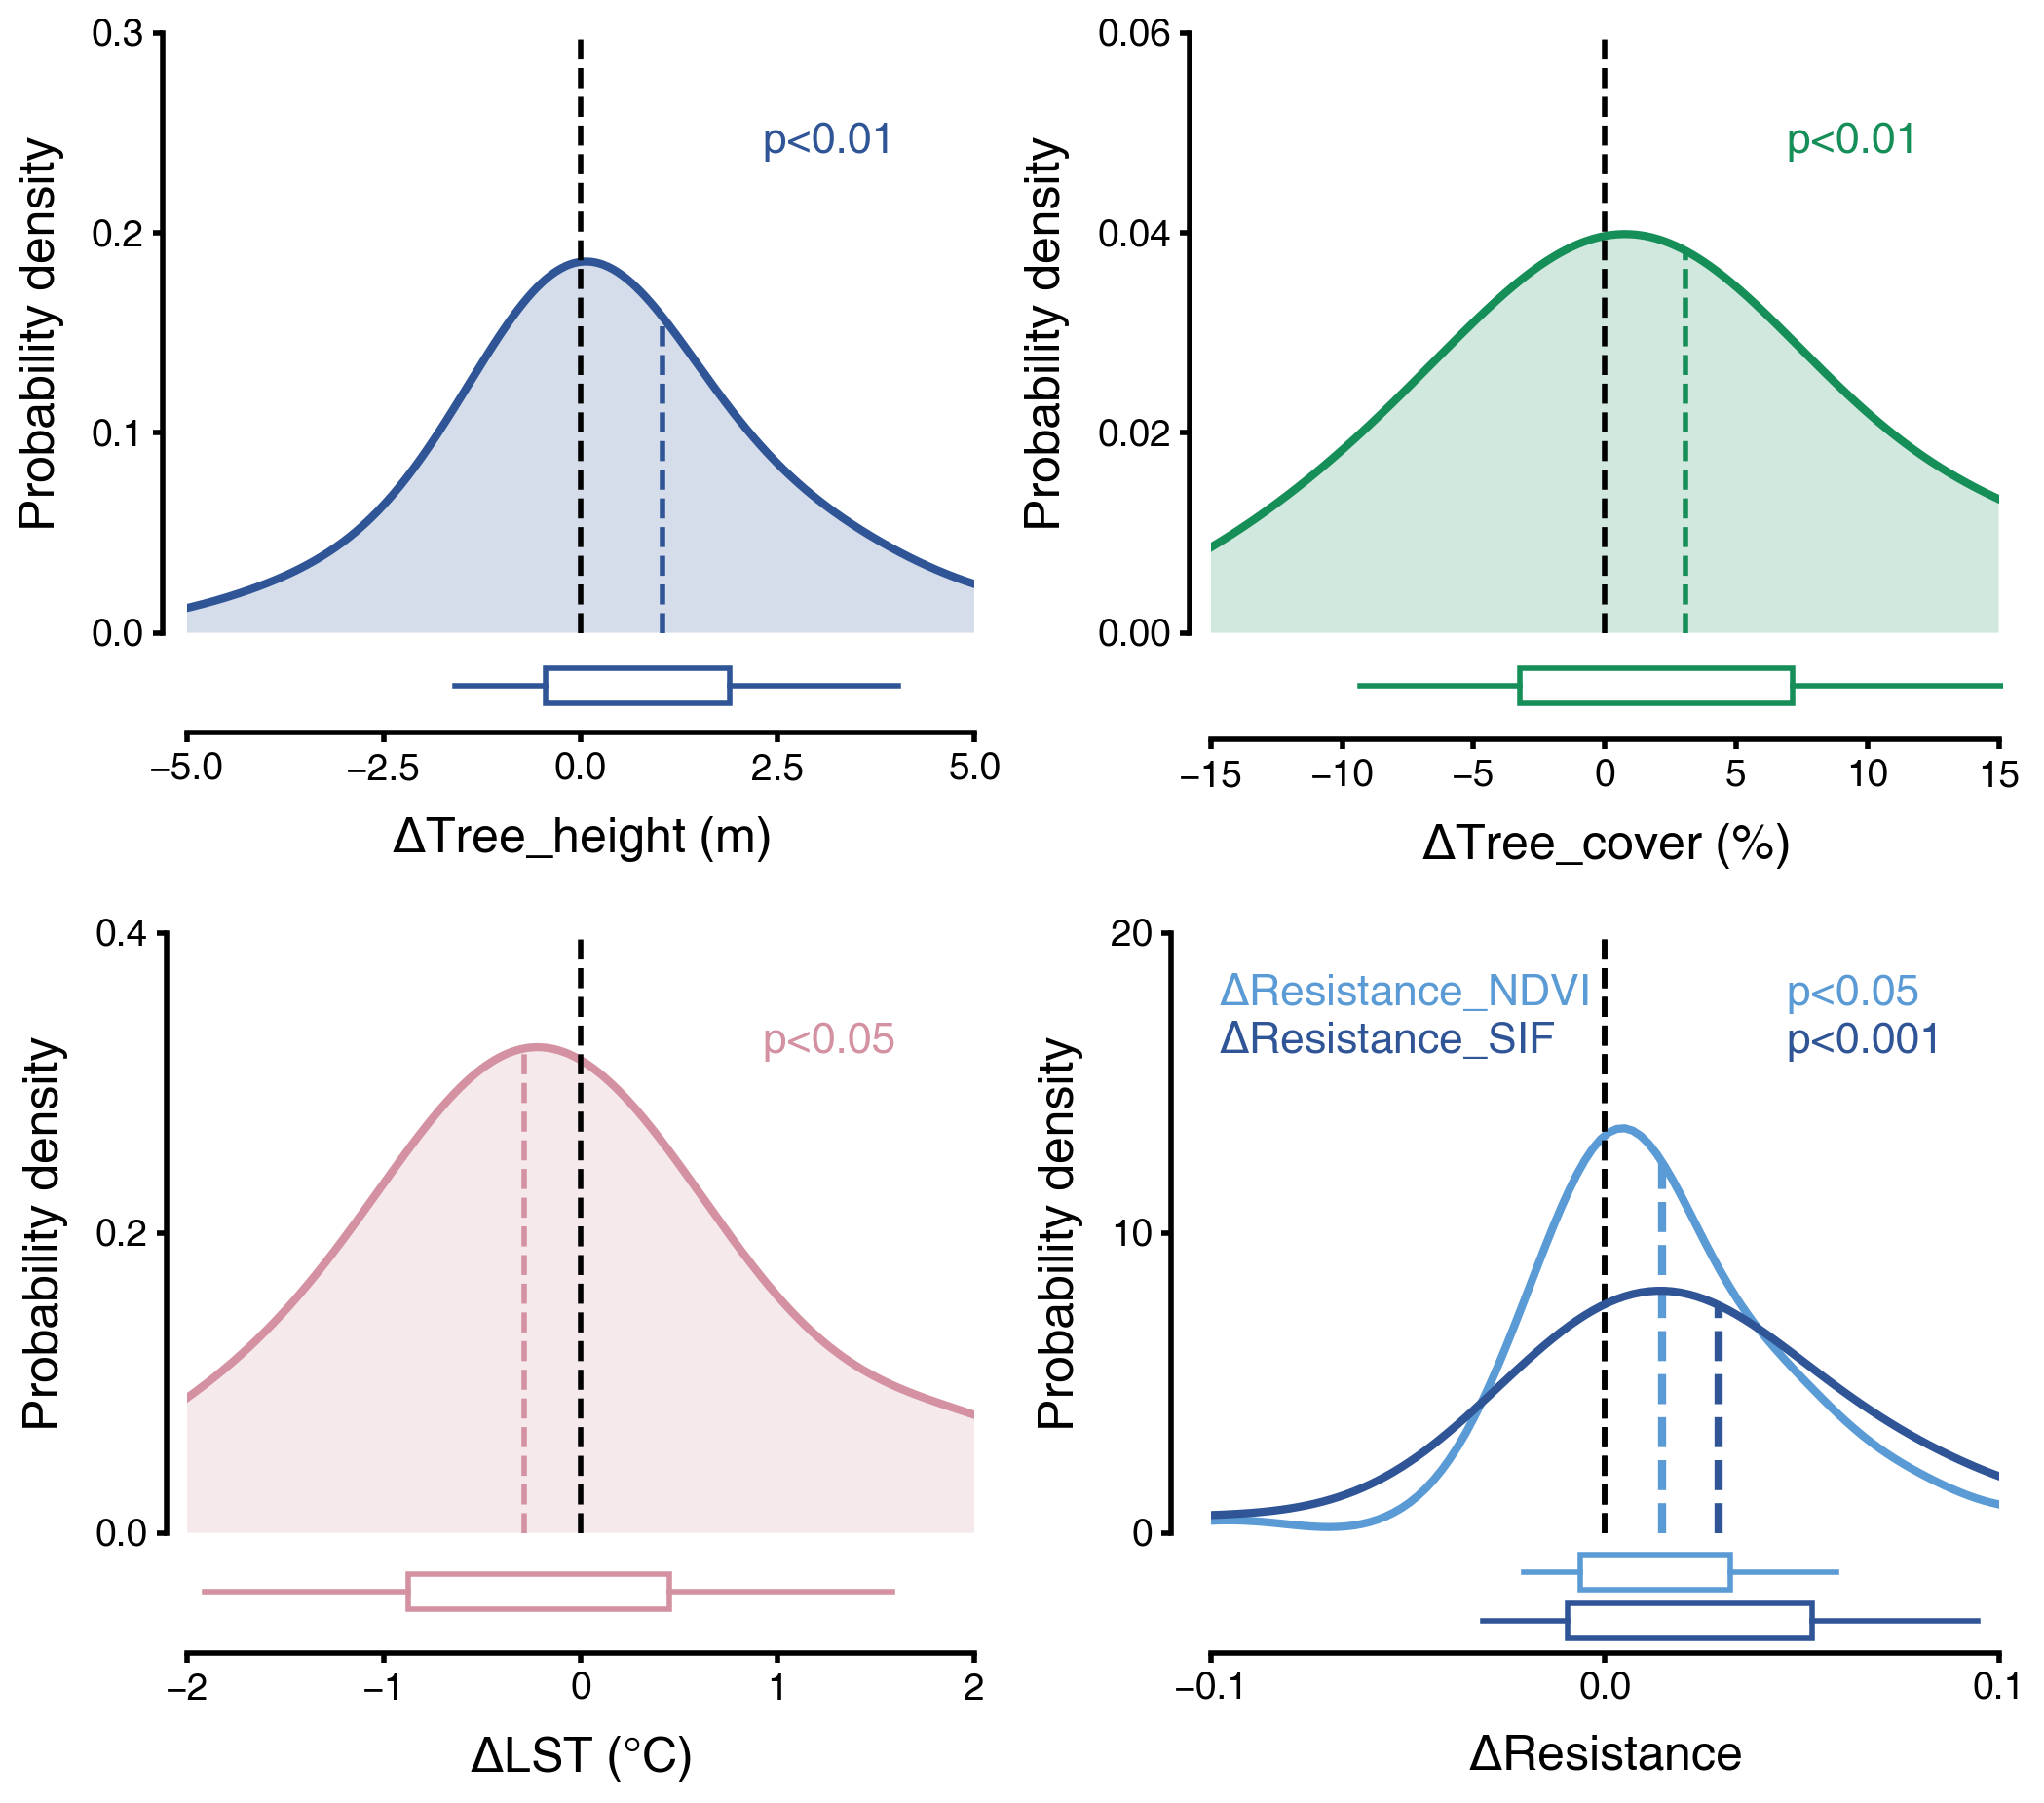

In [30]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(12,10)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)  # pass in the font dict as kwargs
cl1 = np.array([(47,85,151)])#color TH
cl2 = np.array([(22,142,88)])#color TC
cl_veg=[cl1/255,cl2/255]
cl3= np.array([(211,145,161)])#color LST
cl_lst=[cl3/255]
cl4= np.array([(91,155,213)])#color resistance
cl5= np.array([(47,85,151)])#color resistance
cl_res = [cl4/255,cl5/255]#color resistance_NDVI
cl=[cl1/255,cl2/255,cl3/255,cl4/255,cl5/255]

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_ylabel('Probability density',labelpad=10)
    #-----------vegetation structure----------------
    if i<2:
        x=np.linspace(-15,15,1000)
        mean=np.nanmean(data[i])
        delta_rav=gc.nanravel(data[i])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        ax.plot(x,z,lw=3,color=cl[i])#,label=label[i]
        ax.fill_between(x,0,z,facecolor=cl[i],alpha=0.2)
        ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i])
        if pp_value[i]<0.001:
            ax.text(0.73,0.8, 'p<0.001', fontsize=16,transform = ax.transAxes,color=cl[i])
        elif pp_value[i]<0.01:
            ax.text(0.73,0.8, 'p<0.01', fontsize=16,transform = ax.transAxes,color=cl[i])
        elif pp_value[i]<0.05:
            ax.text(0.73,0.8, 'p<0.05', fontsize=16,transform = ax.transAxes,color=cl[i])
        else:
            ax.text(0.73,0.8, 'p={:.2f}'.format(pp_value[i]), fontsize=16,transform = ax.transAxes,color=cl[i])
        if i ==0:
            ax.vlines(0,0,0.3,lw=2,ls='--',color='black')
            ax.set_ylim(0,0.3)
            ax.set_yticks(np.arange(0,0.31,0.1))
            ax.set_xlim(-5,5)
            ax.set_xticks(np.arange(-5,5.1,2.5))
            ax=plt.gca()
            ax.yaxis.set_ticks_position('left')
            ax.spines['left'].set_position(('data',-5.3))
            ax.xaxis.set_ticks_position('bottom')
            ax.spines['bottom'].set_position(('data',-0.05))
            ax.set_xlabel('$\Delta$Tree_height (m)',labelpad=10)
        else:
            ax.vlines(0,0,0.06,lw=2,ls='--',color='black')
            ax.set_ylim(0,0.06)
            ax.set_yticks(np.arange(0,0.061,0.02))
            ax.set_xlim(-15,15)
            ax.set_xticks(np.arange(-15,15.1,5))
            ax=plt.gca()
            ax.yaxis.set_ticks_position('left')
            ax.spines['left'].set_position(('data',-15.8))
            ax.xaxis.set_ticks_position('bottom')
            ax.spines['bottom'].set_position(('data',-0.0107))
            ax.set_xlabel('$\Delta$Tree_cover (%)',labelpad=10)
        #ax.legend(fontsize=14,loc='upper left',frameon=False,handlelength=1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.label.set_size(18)
        ax.xaxis.set_tick_params(width=2)
        ax.tick_params(labelsize=14)
        ax.yaxis.label.set_size(18)
        ax.yaxis.set_tick_params(width=2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        #添加箱线图
        if i ==0:
            ax1=fig.add_axes([0.124,0.515,0.34,0.06])#左，底，宽，高
            ax1.set_xlim(-5,5)
            ax1.set_xticks(np.arange(-5,5,2.5))
            ax1.axis('off')
        else:
            ax1=fig.add_axes([0.562,0.515,0.34,0.06])#左，底，宽，高
            ax1.set_xlim(-15,15)
            ax1.set_xticks(np.arange(-15,15,5))
            ax1.axis('off')
        bplot=ax1.boxplot(data[i],
                          vert=False,
                          whis=(10,90),                
                          widths=0.3,
                          patch_artist=True,
                          showmeans=False,
                          meanprops = {'marker':'o','markerfacecolor':cl[i],"markeredgecolor":cl[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                          medianprops={'linewidth':'0.5',"color":cl[i],"alpha":0},
                          boxprops={"facecolor": 'none', "edgecolor": cl[i],"linewidth":2,"alpha":1},
                          capprops=None,
                          whiskerprops={'linewidth':'2','color':cl[i]},
                          showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                          showfliers = False,
                          flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i],'color':cl[i]})
    #-----------LST----------------
    elif i==2:
        x=np.linspace(-2,2,1000)
        mean=np.nanmean(data[i])
        delta_rav=gc.nanravel(data[i])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        print(mean,z_mean)
        ax.plot(x,z,lw=3,color=cl[i])#,label=label
        ax.fill_between(x,0,z,facecolor=cl[i],alpha=0.2)
        ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl_lst[0])
        ax.vlines(0,0,0.8,lw=2,ls='--',color='black')
        if pp_value[i]<0.001:
            ax.text(0.73,0.8, 'p<0.001', fontsize=16,transform = ax.transAxes,color=cl[i])
        elif pp_value[i]<0.01:
            ax.text(0.73,0.8, 'p<0.01', fontsize=16,transform = ax.transAxes,color=cl[i])
        elif pp_value[i]<0.05:
            ax.text(0.73,0.8, 'p<0.05', fontsize=16,transform = ax.transAxes,color=cl[i])
        else:
            ax.text(0.73,0.8, 'p={:.2f}'.format(pp_value[i]), fontsize=16,transform = ax.transAxes,color=cl[i])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('$\Delta$LST (°C)',labelpad=10)

        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-2.1))
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',-0.08))
        ax.set_ylim(0,0.4)
        ax.set_xlim(-2,2)
        ax.set_xticks(np.arange(-2,2.01,1))
        ax.set_yticks(np.arange(0,0.401,0.2))

        ax.tick_params(labelsize=14)
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        #添加箱线图----------------------------
        ax1=fig.add_axes([0.124,0.05,0.34,0.06])#左，底，宽，高
        ax1.set_xlim(-2,2)
        ax1.set_xticks(np.arange(-2,2.01,1))
        ax1.axis('off')
        bplot=ax1.boxplot(data[i],
                          vert=False,
                          whis=(10,90),                
                          widths=0.3,
                          patch_artist=True,
                          showmeans=False,
                          meanprops = {'marker':'o','markerfacecolor':cl[i],"markeredgecolor":cl[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                          medianprops={'linewidth':'0.5',"color":cl[i],"alpha":0},
                          boxprops={"facecolor": 'none', "edgecolor": cl[i],"linewidth":2,"alpha":1},
                          capprops=None,
                          whiskerprops={'linewidth':'2','color':cl[i]},
                          showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示;
                          showfliers = False,
                          flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i],'color':cl[i]})
    elif i==3:
        for j in range(2):
            x=np.linspace(-0.1,0.1,100)
            ax.vlines(0,0,20,lw=2,ls='--',color='black')
            ax.set_ylim(0,20)
            ax.set_yticks(np.arange(0,20.1,10))
            ax.set_xlim(-0.1,0.1)
            ax.set_xticks(np.arange(-0.1,0.101,0.1))
            ax.set_xlabel('$\Delta$Resistance',labelpad=10)
            mean=np.nanmean(data[i][j])
            delta_rav=gc.nanravel(data[i][j])
            kenal=gaussian_kde(delta_rav)
            z=kenal.evaluate(x)
            z_mean=kenal.evaluate(mean)
            print(mean,z_mean)
            ax.plot(x,z,lw=3,color=cl_res[j])
            ax.vlines(mean,0,z_mean,lw=3,ls='--',color=cl_res[j])
            if pp_value[i][j]<0.001:
                ax.text(0.73,0.80, "p<0.001", fontsize=16,transform = ax.transAxes,color=cl_res[j])
                ax.text(0.01,0.80, "$\Delta$Resistance_SIF", fontsize=16,transform = ax.transAxes,color=cl_res[j])
            elif pp_value[i][j]<0.05:
                ax.text(0.73,0.88, "p<0.05", fontsize=16,transform = ax.transAxes,color=cl_res[j])
                ax.text(0.01,0.88, "$\Delta$Resistance_NDVI", fontsize=16,transform = ax.transAxes,color=cl_res[j])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax=plt.gca()
            ax.yaxis.set_ticks_position('left')
            ax.spines['left'].set_position(('data',-0.11))
            ax.xaxis.set_ticks_position('bottom')
            ax.spines['bottom'].set_position(('data',-4))
            ax.tick_params(labelsize=14)
            ax.xaxis.label.set_size(18)
            ax.yaxis.label.set_size(18)
            ax.xaxis.set_tick_params(width=2)
            ax.yaxis.set_tick_params(width=2)
            ax.spines['left'].set_linewidth(2)
            ax.spines['bottom'].set_linewidth(2)
            if j ==0:
                ax1=fig.add_axes([0.56,0.06,0.34,0.06])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.56,0.035,0.34,0.06])#左，底，宽，高
            ax1.set_xlim(-0.1,0.1)
            ax1.set_xticks(np.arange(-0.1,0.101,0.1))
            ax1.axis('off')
            bplot=ax1.boxplot(data[i][j],
                              vert=False,
                              whis=(10,90),                
                              widths=0.3,
                              patch_artist=True,
                              showmeans=False,
                              meanprops = {'marker':'o','markerfacecolor':cl_res[j],"markeredgecolor":cl_res[j],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                              medianprops={'linewidth':'0.5',"color":cl_res[j],"alpha":0},
                              boxprops={"facecolor": 'none', "edgecolor": cl_res[j],"linewidth":2,"alpha":1},
                              capprops=None,
                              whiskerprops={'linewidth':'2','color':cl_res[j]},
                              showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                              showfliers = False,
                              flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl_res[j],'color':cl_res[j]})
                
